In [1]:
gene_familly = "AP2"

In [2]:
# Parameters
gene_familly = "ARF"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA, DNA_MPI
from visualization import VISU, VISUReport
from feature_selection import SelectKFeature

[MacBook-Pro-de-Genereux.local:38960] shmem: mmap: an error occurred while determining whether or not /var/folders/w8/b_cflrn97k9c15rcrn5t8mmr0000gn/T//ompi.MacBook-Pro-de-Genereux.501/jf.0/2075590656/sm_segment.MacBook-Pro-de-Genereux.501.7bb70000.0 could be created.


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE
gene_info_path = "../data/gene_info_small.json"
trainset_path  = "../data/mix_data/trainset/"
testset_path   = "../data/mix_data/testset/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

# FOCUS ON GENE FAMALLY
gene_dict = gene_info[gene_familly]
df_path = trainset_path+gene_dict['file_code']+".csv"
ts_path = testset_path+gene_dict['file_code']+".csv"

#LOAD DF
USE_FULL_DF = True
if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
    testset = pd.read_csv(ts_path)
else:
    dataset_ = pd.read_csv(df_path)
    testset = pd.read_csv(ts_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)

In [6]:
dataset.head()

,Unnamed: 0,id,sequence,length,class
0,5751,OMERI04G07690.1,MMNSSSTSAVESVTNLQARTPPLPNPVAPKTGGQSEQALKLASTTA...,167,0
1,7681,TRAES3BF021600300CFD_t1,MNHAPPGFRFTPTREELIGYYLNPWVADPGKTPVAELRGIVCVADI...,448,0
2,8118,Itr_sc000075.1_g00010.1,MGEMTDSLTATAPSSRPLPFREDCWSEEATATLVDAWGRRFMELNR...,313,0
3,6849,Niben101Scf03908g02005.1,MGRGKIDIKLIENVNNRQVTFSKRRAGLLKKANELSVLCDAEVAVI...,258,0
4,3819,Seita.3G020000.2.p,MSSSSAASIGQPPPPAAPPEEEKKCLNSELWHACAGPLVCLPTVGT...,816,1


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7301 entries, 0 to 7300
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7301 non-null   int64 
 1   id          7301 non-null   object
 2   sequence    7301 non-null   object
 3   length      7301 non-null   int64 
 4   class       7301 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 285.3+ KB


In [8]:
#sns.set(style="whitegrid")
#sns.violinplot(x=dataset.length)
#plt.title("sequence length distribution in test sequences")
#plt.show()

In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model-ft/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
21**2

441

In [12]:
k        = 2
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=200, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.1])

In [13]:
X_train, y_train, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test.head()

,AA,AC,AI,AL,AP,AR,AT,AY,CA,CC,...,YD,YE,YF,YG,YI,YL,YM,YT,YV,YW
0,0.005747,0.001437,0.002874,0.001437,0.001437,0.002874,0.005747,0.000000,0.001437,0.0,...,0.002874,0.001437,0.001437,0.000000,0.0,0.001437,0.000000,0.002874,0.000000,0.0
1,0.010753,0.002688,0.000000,0.002688,0.005376,0.008065,0.002688,0.000000,0.005376,0.0,...,0.000000,0.000000,0.002688,0.002688,0.0,0.000000,0.002688,0.000000,0.000000,0.0
2,0.000000,0.000000,0.000000,0.003175,0.000000,0.003175,0.003175,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.003175,0.0,0.003175,0.000000,0.000000,0.000000,0.0
3,0.006422,0.000917,0.000000,0.007339,0.001835,0.001835,0.000000,0.000000,0.000917,0.0,...,0.000000,0.001835,0.001835,0.000000,0.0,0.001835,0.000917,0.000917,0.000917,0.0
4,0.032258,0.004032,0.000000,0.012097,0.012097,0.012097,0.004032,0.008065,0.004032,0.0,...,0.008065,0.000000,0.000000,0.008065,0.0,0.000000,0.000000,0.004032,0.000000,0.0


In [14]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7301, 200)
X_test: (1826, 200)
y_train: (7301,)
y_test: (1826,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [15]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,721 (370.00 KB)

 Trainable params: 94,721 (370.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1:11 786ms/step - accuracy: 0.4219 - loss: 0.6932

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6589 - loss: 0.6855    

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7278 - loss: 0.6458

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7743 - loss: 0.5772

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7845 - loss: 0.5583 - val_accuracy: 0.9904 - val_loss: 0.0226


Epoch 2/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0145

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9881 - loss: 0.0355 

53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9888 - loss: 0.0368

79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9889 - loss: 0.0362

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9890 - loss: 0.0358 - val_accuracy: 0.9932 - val_loss: 0.0154


Epoch 3/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0028

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0166 

54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0152

79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0147

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0153 - val_accuracy: 0.9918 - val_loss: 0.0195


Epoch 4/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0338

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9921 - loss: 0.0266 

54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0219

80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0198

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0192 - val_accuracy: 0.9945 - val_loss: 0.0159


Epoch 5/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0025

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0105 

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0094

82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0101

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0101 - val_accuracy: 0.9959 - val_loss: 0.0118


Epoch 6/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0031

26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0053 

53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0073

78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0094

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0104 - val_accuracy: 0.9938 - val_loss: 0.0275


Epoch 7/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0013

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0154 

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0135

81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0123

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0119 - val_accuracy: 0.9938 - val_loss: 0.0193


Epoch 8/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0011

24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0027 

52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0034

81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0041

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0045 - val_accuracy: 0.9945 - val_loss: 0.0174


Epoch 9/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0017

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0037 

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0039

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0042

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0043 - val_accuracy: 0.9754 - val_loss: 0.0654


Epoch 10/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9531 - loss: 0.0830

30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9864 - loss: 0.0304 

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9901 - loss: 0.0224

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.0185

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0179 - val_accuracy: 0.9925 - val_loss: 0.0196


Epoch 11/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 8.5949e-04

30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0058     

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0082

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0086

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0086 - val_accuracy: 0.9973 - val_loss: 0.0126


Epoch 12/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0029

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0041 

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0039

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0041

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0041 - val_accuracy: 0.9932 - val_loss: 0.0217


Epoch 13/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 1.8100e-04

30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0015     

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0026

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0028

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0028 - val_accuracy: 0.9945 - val_loss: 0.0179


Epoch 14/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 2.4288e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 8.9607e-04 

58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0012    

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0025

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0030 - val_accuracy: 0.9938 - val_loss: 0.0216


Epoch 15/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 2.4729e-04

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0070     

56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0053

83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0046

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0045 - val_accuracy: 0.9952 - val_loss: 0.0192


Epoch 16/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0032

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0033 

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0030

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0033

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0034 - val_accuracy: 0.9938 - val_loss: 0.0208


Epoch 17/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 2.1394e-04

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0012     

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0017

81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0035

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0050 - val_accuracy: 0.9856 - val_loss: 0.0354


Epoch 18/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.0327

31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.0149 

60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9931 - loss: 0.0122

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0103

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0101 - val_accuracy: 0.9938 - val_loss: 0.0277


Epoch 19/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 2.4486e-04

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0013     

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0010

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0015

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0016 - val_accuracy: 0.9938 - val_loss: 0.0303


Epoch 20/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 1.4763e-04

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0032     

54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0031

82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0035

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0035 - val_accuracy: 0.9932 - val_loss: 0.0226


Epoch 21/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0037

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0043 

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0064

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0068

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0067 - val_accuracy: 0.9938 - val_loss: 0.0163



[Train Accuracy: 99.83% - Test Accuracy: 99.56%]


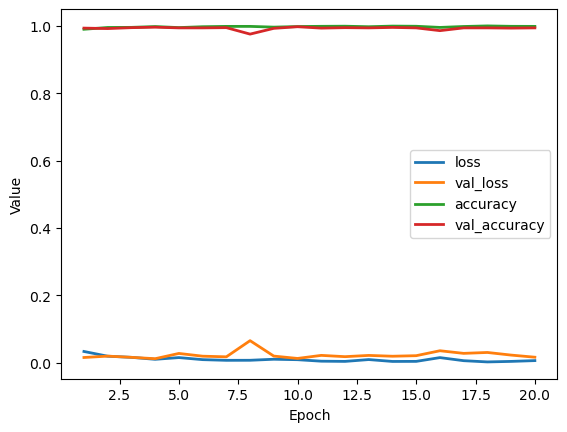

In [16]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [17]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/58 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step


 1/58 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [18]:
21**3

9261

In [19]:
k        = 3
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['rf', 0.1])

In [20]:
X_train, y_train, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test.head()

,YFP,TGW,RHL,CAG,PRR,HLL,LLT,LTT,LVA,RHI,...,SFV,SIK,WGL,QAE,PSQ,HPT,ILV,PIL,VEI,PIE
0,0.001439,0.001439,0.001439,0.001439,0.001439,0.001439,0.001439,0.001439,0.002878,0.000000,...,0.0,0.001439,0.0,0.0,0.001439,0.0,0.0,0.0,0.000000,0.0
1,0.002695,0.002695,0.002695,0.002695,0.002695,0.002695,0.002695,0.002695,0.002695,0.002695,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.002695,0.0
2,0.000000,0.000000,0.003185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,0.000918,0.000918,0.000918,0.000918,0.000918,0.000918,0.001837,0.000918,0.000918,0.000918,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,0.004049,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [21]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7301, 1000)
X_test: (1826, 1000)
y_train: (7301,)
y_test: (1826,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 299,521 (1.14 MB)

 Trainable params: 299,521 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1:01 679ms/step - accuracy: 0.5000 - loss: 0.6932

21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6822 - loss: 0.6894    

43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7782 - loss: 0.6689

64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8248 - loss: 0.6199

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8537 - loss: 0.5620

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8620 - loss: 0.5417 - val_accuracy: 0.9966 - val_loss: 0.0101


Epoch 2/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0040

20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - loss: 0.0124 

39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9966 - loss: 0.0153

58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9962 - loss: 0.0161

76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9962 - loss: 0.0159

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9962 - loss: 0.0154 - val_accuracy: 0.9973 - val_loss: 0.0092


Epoch 3/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 5.4887e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.3701e-04 

38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0012    

56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0016

75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0018

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0018 - val_accuracy: 0.9979 - val_loss: 0.0068


Epoch 4/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 1.7932e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0016     

38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0014

58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012

77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0011

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9979 - val_loss: 0.0093


Epoch 5/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0021

20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012 

39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.1308e-04

58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.9796e-04

77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.2202e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.7153e-04 - val_accuracy: 0.9986 - val_loss: 0.0064


Epoch 6/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9844 - loss: 0.0206

20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9972 - loss: 0.0049 

39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0033

58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0026

77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0022

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0020 - val_accuracy: 0.9979 - val_loss: 0.0055


Epoch 7/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 1.0730e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.1684e-04 

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.6553e-04

56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.4362e-04

74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.2172e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.0028e-04 - val_accuracy: 0.9986 - val_loss: 0.0073


Epoch 8/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 8.2209e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9972 - loss: 0.0046     

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - loss: 0.0039

56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.0034

75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0031

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0028 - val_accuracy: 0.9986 - val_loss: 0.0062


Epoch 9/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 4.2659e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.1849e-05 

40/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.6550e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.3364e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.0889e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.9821e-05 - val_accuracy: 0.9986 - val_loss: 0.0066


Epoch 10/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 5.6636e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012     

39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.4963e-04

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.8978e-04

76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.8405e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.1772e-04 - val_accuracy: 0.9986 - val_loss: 0.0070


Epoch 11/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 3.8184e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.0157e-05 

39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.0263e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.7810e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.6326e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.5309e-05 - val_accuracy: 0.9986 - val_loss: 0.0072


Epoch 12/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 3.7545e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.7544e-05 

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.7052e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.6770e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.7663e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.1365e-05 - val_accuracy: 0.9986 - val_loss: 0.0061


Epoch 13/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 3.7411e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.3189e-04 

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.7900e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 8.1765e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.1225e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.4913e-05 - val_accuracy: 0.9986 - val_loss: 0.0067


Epoch 14/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 1.2773e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.3630e-05 

38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.9272e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.9779e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.0729e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.0828e-05 - val_accuracy: 0.9986 - val_loss: 0.0070


Epoch 15/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 1.1381e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.0919e-05 

38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.0034e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.8084e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.7122e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.7005e-05 - val_accuracy: 0.9986 - val_loss: 0.0074



[Train Accuracy: 100.00% - Test Accuracy: 99.84%]


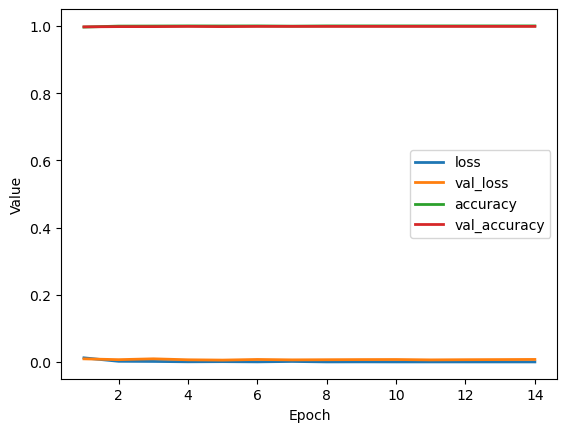

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/58 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step


 1/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [25]:
21**4

194481

In [26]:
k        = 4
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.1])

In [27]:
X_train, y_train, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AAAH,AAED,AAEK,AAHA,AATN,ACAG,ADEC,ADPE,ADPP,ADVE,...,YQAM,YRGQ,YRGT,YTDD,YTKV,YVDH,YVKA,YYFP,YYKP,YYPR
0,0.0,0.0,0.000000,0.0,0.0,0.001441,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.001441,0.0,0.000000,0.0,0.000000,0.001441,0.000000
1,0.0,0.0,0.000000,0.0,0.0,0.002703,0.0,0.002703,0.002703,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.002703,0.000000,0.002703
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
3,0.0,0.0,0.000919,0.0,0.0,0.000919,0.0,0.000000,0.000000,0.0,...,0.0,0.000919,0.0,0.000000,0.0,0.000919,0.0,0.000000,0.000000,0.000000
4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000


In [28]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [29]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,473 (1.13 MB)

 Trainable params: 297,473 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 59s 651ms/step - accuracy: 0.5469 - loss: 0.6931

21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5541 - loss: 0.6912   

41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6121 - loss: 0.6814

62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6731 - loss: 0.6532

81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7139 - loss: 0.6160

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7344 - loss: 0.5909 - val_accuracy: 0.9760 - val_loss: 0.0636


Epoch 2/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0222

20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9921 - loss: 0.0354 

39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9928 - loss: 0.0331

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9926 - loss: 0.0325

80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9926 - loss: 0.0319

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9927 - loss: 0.0315 - val_accuracy: 0.9925 - val_loss: 0.0244


Epoch 3/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9844 - loss: 0.0451

20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9916 - loss: 0.0343 

39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9929 - loss: 0.0295

58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9938 - loss: 0.0261

77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9944 - loss: 0.0238

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9947 - loss: 0.0224 - val_accuracy: 0.9959 - val_loss: 0.0139


Epoch 4/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0078

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9959 - loss: 0.0213 

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9956 - loss: 0.0197

56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9958 - loss: 0.0181

76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9961 - loss: 0.0167

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9963 - loss: 0.0157 - val_accuracy: 0.9952 - val_loss: 0.0189


Epoch 5/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 6.1591e-04

20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9941 - loss: 0.0158     

39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9952 - loss: 0.0141

58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9957 - loss: 0.0129

76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9960 - loss: 0.0119

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9962 - loss: 0.0115 - val_accuracy: 0.9959 - val_loss: 0.0136


Epoch 6/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0012

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0034 

38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0045

56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0048

74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0050

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0053 - val_accuracy: 0.9973 - val_loss: 0.0080


Epoch 7/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0047

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0043 

38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0051

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0052

76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0064

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0072 - val_accuracy: 0.9973 - val_loss: 0.0082


Epoch 8/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0059

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0040 

38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0046

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0047

75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0048

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0047 - val_accuracy: 0.9973 - val_loss: 0.0080


Epoch 9/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0014

20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0036 

39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0033

58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0031

76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0030

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0029 - val_accuracy: 0.9973 - val_loss: 0.0079


Epoch 10/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 8.5826e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0019     

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0018

56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0022

74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0025

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0026 - val_accuracy: 0.9986 - val_loss: 0.0070


Epoch 11/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 6.4153e-04

20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0040     

38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0042

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0039

75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0036

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0034

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0033 - val_accuracy: 0.9973 - val_loss: 0.0116


Epoch 12/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 3.9413e-04

18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0050     

36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0038

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0031

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0028

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0028

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0028 - val_accuracy: 0.9979 - val_loss: 0.0075


Epoch 13/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 4.9208e-04

18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.9411e-04 

35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.7753e-04

53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 6.3694e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 7.6778e-04

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 8.2756e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 8.3789e-04 - val_accuracy: 0.9986 - val_loss: 0.0078


Epoch 14/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 1.7886e-04

18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0030     

36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0025

53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0021

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0019

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0017

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0017 - val_accuracy: 0.9973 - val_loss: 0.0111


Epoch 15/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 1.0406e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.5786e-04 

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.6780e-04

54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.0218e-04

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.4771e-04

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.5934e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.6098e-04 - val_accuracy: 0.9986 - val_loss: 0.0069


Epoch 16/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 1.2533e-04

18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.4719e-04 

36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.2605e-04

54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.2954e-04

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 6.1670e-04

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 7.8650e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 8.1174e-04 - val_accuracy: 0.9979 - val_loss: 0.0109


Epoch 17/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 1.8006e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.8094e-04 

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.1993e-04

54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.3004e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.3388e-04

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.4871e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.5753e-04 - val_accuracy: 0.9966 - val_loss: 0.0063


Epoch 18/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0023

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.9387e-04

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 8.1363e-04

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 9.8350e-04

74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0010    

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0010

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0010 - val_accuracy: 0.9979 - val_loss: 0.0122


Epoch 19/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0025

20/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.4258e-04

38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.9450e-04

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 3.2730e-04

75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.8312e-04

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.6012e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.5776e-04 - val_accuracy: 0.9986 - val_loss: 0.0094


Epoch 20/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 5.6043e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.6519e-04 

35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 2.7362e-04

53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 6.9617e-04

70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 8.4532e-04

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 8.9436e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 8.9943e-04 - val_accuracy: 0.9986 - val_loss: 0.0071



[Train Accuracy: 99.97% - Test Accuracy: 99.95%]


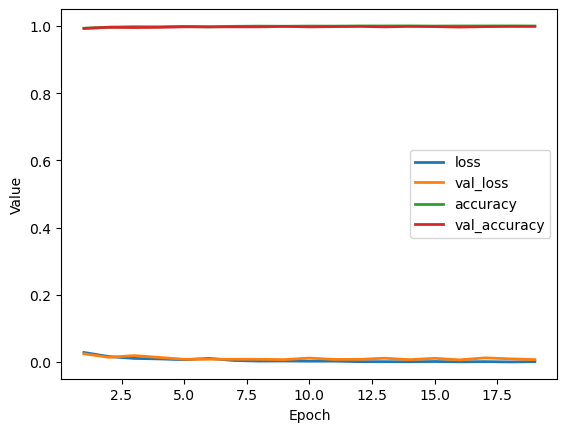

In [30]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step


 1/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step


In [32]:
#report.save()

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [33]:
21**5

4084101

In [34]:
k        = 5
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=min(1300/len(dataset), 1), discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.00001]);

In [35]:
k = 5
X_train, y_train, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AAAAH,AAAHA,AAATN,AAEDC,AAEKI,AAEKV,AAHAA,AASTN,AATNS,ACAGG,...,YPSPF,YRGQP,YRGTP,YTDDE,YTKVQ,YVDHE,YVKAV,YYFPQ,YYKPR,YYPRA
0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.00000,0.0,0.001443,0.0,0.00000,0.0,0.00000,0.001443,0.00000
1,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00271,...,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0.00271,0.000000,0.00271
2,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0.00000,0.000000,0.00000
3,0.0,0.0,0.0,0.0,0.00092,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.00092,0.0,0.000000,0.0,0.00092,0.0,0.00000,0.000000,0.00000
4,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0.00000,0.000000,0.00000


In [36]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [37]:
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 586,497 (2.24 MB)

 Trainable params: 586,497 (2.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 56s 617ms/step - accuracy: 0.6562 - loss: 0.6932

15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5407 - loss: 0.6923   

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5709 - loss: 0.6876

42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6066 - loss: 0.6771

56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6461 - loss: 0.6570

69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6771 - loss: 0.6316

83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7046 - loss: 0.6010

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7213 - loss: 0.5792 - val_accuracy: 0.9856 - val_loss: 0.0398


Epoch 2/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0125

15/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9868 - loss: 0.0531 

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9866 - loss: 0.0508

41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9868 - loss: 0.0497

54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9867 - loss: 0.0505

66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9868 - loss: 0.0502

78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9871 - loss: 0.0495

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9872 - loss: 0.0489

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9873 - loss: 0.0488 - val_accuracy: 0.9973 - val_loss: 0.0256


Epoch 3/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.0404

13/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9952 - loss: 0.0399 

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9934 - loss: 0.0419

36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9931 - loss: 0.0409

47/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9929 - loss: 0.0398

60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9928 - loss: 0.0384

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9928 - loss: 0.0376

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9927 - loss: 0.0370

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9928 - loss: 0.0364 - val_accuracy: 0.9952 - val_loss: 0.0188


Epoch 4/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9844 - loss: 0.0695

13/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9910 - loss: 0.0416 

24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9924 - loss: 0.0356

36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9929 - loss: 0.0334

48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9932 - loss: 0.0315

61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9936 - loss: 0.0297

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9938 - loss: 0.0283

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9941 - loss: 0.0271

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9942 - loss: 0.0265 - val_accuracy: 0.9979 - val_loss: 0.0110


Epoch 5/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 0.0127

14/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9984 - loss: 0.0101 

26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9972 - loss: 0.0128

38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9967 - loss: 0.0143

50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9963 - loss: 0.0155

63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9961 - loss: 0.0161

74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9961 - loss: 0.0164

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9960 - loss: 0.0168

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9960 - loss: 0.0170 - val_accuracy: 0.9973 - val_loss: 0.0128


Epoch 6/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0023

13/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9972 - loss: 0.0109 

24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9960 - loss: 0.0159

36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9954 - loss: 0.0188

48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9952 - loss: 0.0200

61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9952 - loss: 0.0203

74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9953 - loss: 0.0202

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9954 - loss: 0.0200

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9954 - loss: 0.0198 - val_accuracy: 0.9973 - val_loss: 0.0112


Epoch 7/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9844 - loss: 0.0473

14/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9958 - loss: 0.0156 

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9963 - loss: 0.0160

39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9964 - loss: 0.0159

51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9964 - loss: 0.0156

62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9964 - loss: 0.0160

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9963 - loss: 0.0164

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9963 - loss: 0.0166

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9963 - loss: 0.0167 - val_accuracy: 0.9973 - val_loss: 0.0094


Epoch 8/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0021

12/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9973 - loss: 0.0159 

24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9979 - loss: 0.0117

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9978 - loss: 0.0114

49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9978 - loss: 0.0109

61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9977 - loss: 0.0111

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9975 - loss: 0.0118

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9973 - loss: 0.0123

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9973 - loss: 0.0126 - val_accuracy: 0.9973 - val_loss: 0.0120


Epoch 9/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0023

13/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9946 - loss: 0.0152 

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9955 - loss: 0.0149

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9959 - loss: 0.0152

48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9962 - loss: 0.0149

60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9964 - loss: 0.0147

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9965 - loss: 0.0146

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9967 - loss: 0.0145

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9968 - loss: 0.0143 - val_accuracy: 0.9973 - val_loss: 0.0085


Epoch 10/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0038

13/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9974 - loss: 0.0125 

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9972 - loss: 0.0139

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9973 - loss: 0.0136

49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9974 - loss: 0.0132

60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9975 - loss: 0.0132

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9975 - loss: 0.0131

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9976 - loss: 0.0129

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9976 - loss: 0.0129 - val_accuracy: 0.9973 - val_loss: 0.0105


Epoch 11/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0059

14/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9989 - loss: 0.0089 

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9980 - loss: 0.0124

38/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9976 - loss: 0.0137

49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9975 - loss: 0.0139

61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9975 - loss: 0.0137

74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9975 - loss: 0.0136

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9975 - loss: 0.0136

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9975 - loss: 0.0135 - val_accuracy: 0.9973 - val_loss: 0.0089


Epoch 12/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0014

13/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9976 - loss: 0.0071 

24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9972 - loss: 0.0090

35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9973 - loss: 0.0090

46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9975 - loss: 0.0085

58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9976 - loss: 0.0084

70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9978 - loss: 0.0084

82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9978 - loss: 0.0087

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9978 - loss: 0.0089 - val_accuracy: 0.9973 - val_loss: 0.0094


Epoch 13/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0012

12/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0014 

24/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0018

35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9993 - loss: 0.0038

46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9989 - loss: 0.0050

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9986 - loss: 0.0063

69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9983 - loss: 0.0072

81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9981 - loss: 0.0078

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9980 - loss: 0.0084 - val_accuracy: 0.9973 - val_loss: 0.0087


Epoch 14/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 7.6278e-04

13/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9980 - loss: 0.0043     

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9982 - loss: 0.0050

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9982 - loss: 0.0063

49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9981 - loss: 0.0072

60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9980 - loss: 0.0080

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9978 - loss: 0.0093

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9976 - loss: 0.0100

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9975 - loss: 0.0103 - val_accuracy: 0.9973 - val_loss: 0.0089



[Train Accuracy: 99.69% - Test Accuracy: 99.67%]


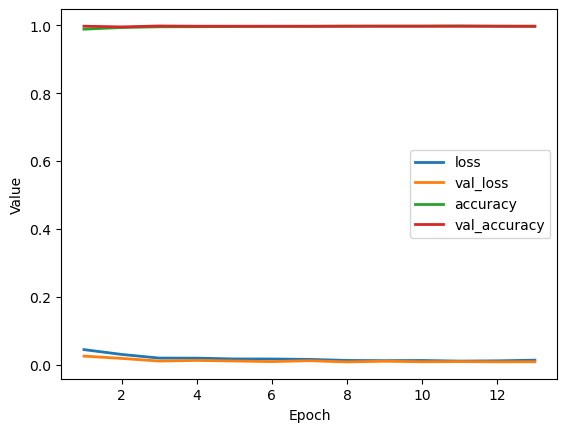

In [38]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [39]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('-ft')

 1/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 1/58 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step


Report saved as Output/Reports/ARF/report_full_4MYY72CH.html


In [40]:
# END

In [41]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################